# Face Recognition

The following codes are based on the following LinkedIn Learning course: https://www.linkedin.com/learning/deep-learning-face-recognition

The face dataset is obtained from Labelled Faces in the Wild (LFW):
https://www.kaggle.com/jessicali9530/lfw-dataset

---
### Mount to Google Drive
Mount to your Google Drive to access the images and model files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset_location = "/content/drive/My Drive/Crafting/AdvCVDL/dataset/"

Mounted at /content/drive


---
## Import the required libraries

* Remove the comment if the import fails.
* put back the comment after installing the library

In [4]:
#!pip install dlib
#!pip install face_recognition

import face_recognition
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from imutils import paths

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=9ebc4087f9718f556d962ec2140241b71c68e0eb1fd2390c9248b7b4136719c7
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


---
## Load the csv file with the Face Encodings

In [5]:
face_encodings_csv = dataset_location+"Face/KnownFaceEncodings.csv"
# Load the csv file with the Face Encodings
Known_db = pd.read_csv(face_encodings_csv)

# Split the Name with the Face Encodings
known_face_encodings = Known_db.iloc[:, 1:].to_numpy()
known_face_name = Known_db.iloc[:, 0].to_numpy()

print(known_face_encodings.shape)
print(known_face_name.shape)

(50, 128)
(50,)


---
## Read an image and perform Face Recognition

[INFO] Jennifer_Garner_0003 -( 841 , 213 ) - ( 1174 , 546 ) - 48.44%
[INFO] Unknown -( 115 , 424 ) - ( 393 , 701 ) - 28.96%
[INFO] Unknown -( 1502 , 239 ) - ( 1779 , 517 ) - 34.63%


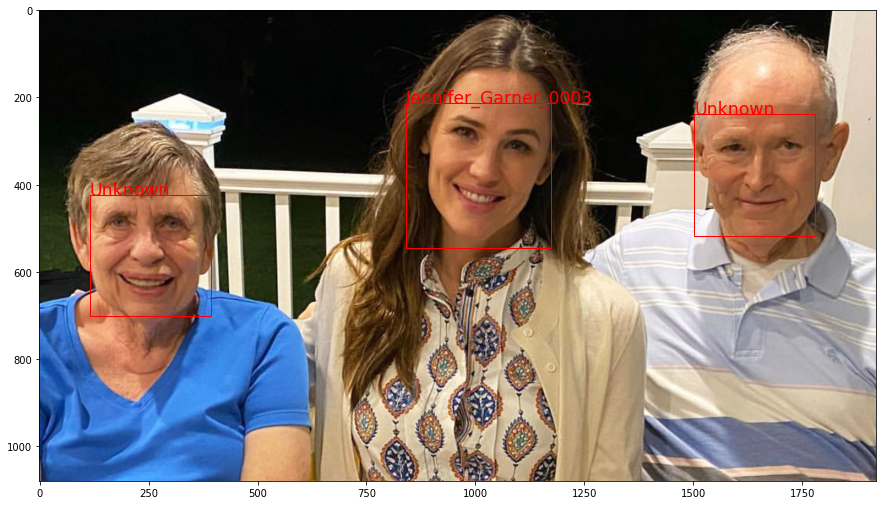

In [6]:
# Load the image we want to check
unknown_image = face_recognition.load_image_file(dataset_location+"Face/LFW_Test/1_1.jpg")

plt.figure(figsize=(15, 15))
plt.imshow(unknown_image)
ax = plt.gca()

# Get face encodings for any people in the picture
face_locations = face_recognition.face_locations(unknown_image, number_of_times_to_upsample=2)
unknown_face_encodings = face_recognition.face_encodings(unknown_image, known_face_locations=face_locations)

# There might be more than one person in the photo, so we need to loop over each face we found
for unknown_face_encoding, face_location in zip(unknown_face_encodings, face_locations):

    # Test the distance between each unknown face with all known faces
    FaceDistance = face_recognition.face_distance(known_face_encodings, unknown_face_encoding)
    # Test of the unknown face is found in all known faces
    results = face_recognition.compare_faces(known_face_encodings, unknown_face_encoding, tolerance=0.52)
    
    # Obtain the index with the shortest distance
    minFaceDistance = np.argmin(FaceDistance)
    # Calculate the confidence level
    confidence = (1 - FaceDistance[minFaceDistance])*100

    # Obtain the name from the found index
    if results[minFaceDistance]:
      name = known_face_name[minFaceDistance]
    else:
      name = "Unknown"
    
    # Extract the corrdinates of the face location
    y1, x2, y2, x1 = face_location

    print("[INFO]",name,"-(",x1,",",y1,") - (",x2,",",y2,") - {:.2f}%".format(confidence))

    # Draw the bounding box    
    ax.add_patch(
         patches.Rectangle(
            (x1, y1),
            (x2 - x1),
            (y2 - y1),
            edgecolor = 'red',
            fill=False      # remove background
         ) ) 
    
    # Display the name
    plt.text(x1, y1, name, fontsize='xx-large', color='red')

plt.show()

---
## Real-time Face Recognition through webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
try:
  filename = take_photo(dataset_location+"temp.jpg")
except Exception as err:
  print(str(err))

# Load the image we want to check
unknown_image = face_recognition.load_image_file(filename)

plt.figure(figsize=(15, 15))
plt.imshow(unknown_image)
ax = plt.gca()

# Get face encodings for any people in the picture
face_locations = face_recognition.face_locations(unknown_image, number_of_times_to_upsample=2)
unknown_face_encodings = face_recognition.face_encodings(unknown_image, known_face_locations=face_locations)

# There might be more than one person in the photo, so we need to loop over each face we found
for unknown_face_encoding, face_location in zip(unknown_face_encodings, face_locations):

    # Test the distance between each unknown face with all known faces
    FaceDistance = face_recognition.face_distance(known_face_encodings, unknown_face_encoding)
    # Test of the unknown face is found in all known faces
    results = face_recognition.compare_faces(known_face_encodings, unknown_face_encoding, tolerance=0.5)
    
    # Obtain the index with the shortest distance
    minFaceDistance = np.argmin(FaceDistance)
    # Calculate the confidence level
    confidence = (1 - FaceDistance[minFaceDistance])*100

    # Obtain the name from the found index
    if results[minFaceDistance]:
      name = known_face_name[minFaceDistance]
    else:
      name = "Unknown"
    
    # Extract the corrdinates of the face location
    y1, x2, y2, x1 = face_location

    print("[INFO]",name,"-(",x1,",",y1,") - (",x2,",",y2,") - {:.2f}%".format(confidence))

    # Draw the bounding box    
    ax.add_patch(
         patches.Rectangle(
            (x1, y1),
            (x2 - x1),
            (y2 - y1),
            edgecolor = 'r',
            fill=False      # remove background
         ) ) 
    
    # Display the name
    plt.text(x1, y1, name, fontsize=12, color='r')

plt.show()